In [5]:
import scipy.stats
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest

In [6]:
# Read in csv file and print out the number of rows
df = pd.read_csv('GPTarget2024.csv')

In [7]:
# Function for proportions and statistical test
def calculate_and_test(group1, group2):
    # Number of 'AI' counts for the groups
    count = np.array([grouped[group1], grouped[group2]])

    # Total observations for the groups
    nobs = np.array([total[group1], total[group2]])

    # Run the test
    zstat, pvalue = proportions_ztest(count, nobs)

    # Print the results
    print(f'\nStatistical Significance Test Results for {group1} vs {group2}:')
    print('Z-statistic:', zstat)
    print('P-value:', pvalue)

# Calculate proportions for each condition who thought the message was authored by an AI
grouped = df[df['authorship'] == 'AI'].groupby('treatment_condition').size()
total = df.groupby('treatment_condition').size()
proportions = grouped / total

# Print the result
print("Proportions of each condition who thought the message was authored by an AI:")
print(proportions)

# Run statistical tests
calculate_and_test('microtargeting', 'no microtargeting')
calculate_and_test('microtargeting', 'false microtargeting')

Proportions of each condition who thought the message was authored by an AI:
treatment_condition
control                      NaN
false microtargeting    0.162842
microtargeting          0.170315
no microtargeting       0.142558
dtype: float64

Statistical Significance Test Results for microtargeting vs no microtargeting:
Z-statistic: 2.5178315932849085
P-value: 0.01180797637542031

Statistical Significance Test Results for microtargeting vs false microtargeting:
Z-statistic: 0.5574783294468776
P-value: 0.577200661133789


/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_92698/1436821496.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['meta_perception'] = pd.Categorical(df_filtered['meta_perception'], categories=desired_values, ordered=True)


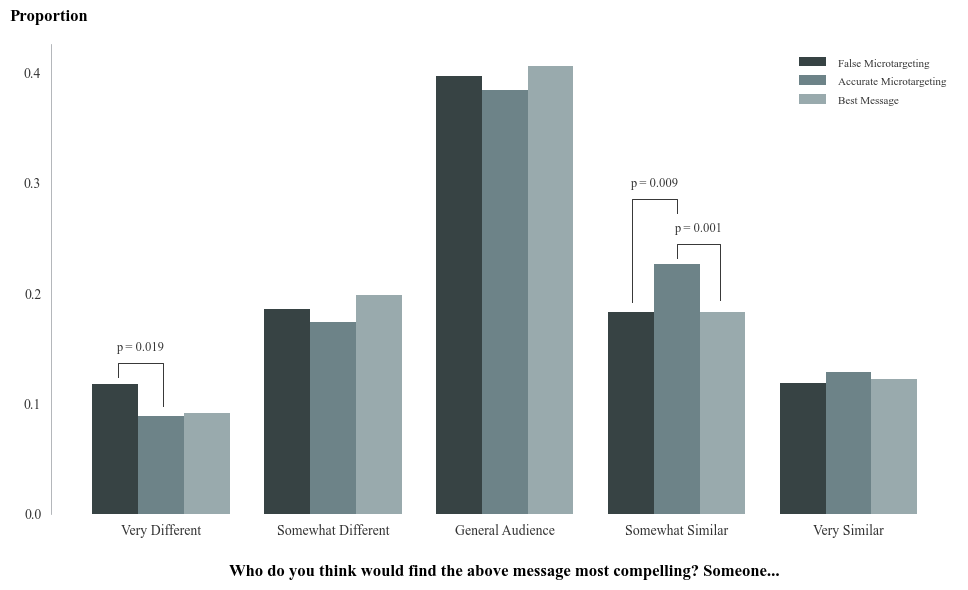

In [19]:
#FIGURE 5
COLOR_MAP = ['#354546', '#69868C', '#96ACB0']
# Preprocess to calculate proportions
desired_values = ["very_different", "somewhat_different", "general_audience", "somewhat_similar", "very_similar"]
df_filtered = df[(df['treatment_condition'] != 'control') & df['meta_perception'].isin(desired_values)]

# Convert 'meta_perception' to a categorical type with the desired order
df_filtered['meta_perception'] = pd.Categorical(df_filtered['meta_perception'], categories=desired_values, ordered=True)

df_filtered = df_filtered.assign(count = 1)
df_proportions = df_filtered.groupby(['treatment_condition', 'meta_perception']).count().rename(columns={'count':'proportion'})
df_proportions = df_proportions / df_proportions.groupby(level=0).sum()

treatments = ['false microtargeting', 'no microtargeting', 'microtargeting']  

# Reset index to make grouped columns accessible for plotting
df_proportions.reset_index(inplace=True)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Set the number of ticks on the y-axis to 5
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Plot all groups on the same chart with bars side by side
sns.barplot(data=df_proportions, x='meta_perception', y='proportion', hue='treatment_condition', palette=COLOR_MAP, edgecolor='none')

# Get current axis
ax = plt.gca()

# Clean up the labels, making them horizontal and bold
labels = [label.get_text().replace('_', ' ').title() for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation='horizontal')

# Set the new x-axis label with labelpad to adjust vertical position
ax.set_xlabel("Who do you think would find the above message most compelling? Someone...", fontsize=12, weight='bold', labelpad=20)

# Rotate y-axis label for better readability and make it bold
ax.set_ylabel('', rotation='horizontal', weight='bold', labelpad=40)
ax.text(-0.65, .45, 'Proportion', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust spines color and linewidth
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Adjust tick parameters
ax.tick_params(colors='#333333')
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()

# Define mapping dictionary
label_dict = {
    'false microtargeting': 'False Microtargeting',
    'microtargeting': 'Accurate Microtargeting',
    'no microtargeting': 'Best Message'
}

# Change labels as per the dictionary
labels = [label_dict[label] if label in label_dict else label for label in labels]

# Apply the new legend
legend = ax.legend(handles, labels, edgecolor='#94999E')
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

plt.tight_layout()

# Function to add brackets and p-values
def add_pvalue(ax, coordinates, pvalue, color='#333333', linewidth=0.7, y_height_factor=0.5, bracket_factor_left=0.1, bracket_factor_right=0.1, fontsize=9):
    x1, x2 = coordinates
    y, h_left, h_right = np.max([ax.get_ylim()])*y_height_factor, np.max([ax.get_ylim()])*bracket_factor_left, np.max([ax.get_ylim()])*bracket_factor_right
    ax.plot([x1, x1, x2, x2], [y-h_left, y, y, y-h_right], lw=linewidth, c=color)
    
    label_y = np.max([ax.get_ylim()])*y_height_factor + np.max([ax.get_ylim()])*0.02  # Change the multiplier here to adjust the vertical position of the label
    ax.text((x1+x2)*.5, label_y, f"p = {pvalue:.3f}", ha='center', va='bottom', color=color, fontsize=fontsize)

# List of perceptions
perceptions = ['very_different', 'somewhat_different', 'general_audience', 'somewhat_similar', 'very_similar']

# Initialize an empty dictionary to store p-values for each perception
pvalues_dict = {}

# Calculate p-values for each perception
for perception in perceptions:
    df_subset = df[df['meta_perception'] == perception]
    pvalues = []
    for treatment1, treatment2 in itertools.combinations(treatments, 2):
        count1 = df_subset[df_subset['treatment_condition'] == treatment1].shape[0]
        count2 = df_subset[df_subset['treatment_condition'] == treatment2].shape[0]
        nobs1 = df[df['treatment_condition'] == treatment1].shape[0]
        nobs2 = df[df['treatment_condition'] == treatment2].shape[0]
        z, p = proportions_ztest([count1, count2], [nobs1, nobs2])
        pvalues.append(p)
    
    # Adjust p-values for multiple comparisons
    pvalues = multipletests(pvalues, method='bonferroni')[1]
    
    # Add p-values to dictionary
    pvalues_dict[perception] = pvalues

# Add brackets and p-values
#add_pvalue(ax, coordinates=[-0.25, 0.25], pvalue=pvalues_dict['very_different'][0], y_height_factor=0.42, bracket_factor_left=0.03, bracket_factor_right=0.19)
add_pvalue(ax, coordinates=[-.25, .009], pvalue=pvalues_dict['very_different'][1], y_height_factor=0.32, bracket_factor_left=0.03, bracket_factor_right=0.09)

add_pvalue(ax, coordinates=[3.0, 2.74], pvalue=pvalues_dict['somewhat_similar'][1], y_height_factor=0.67, bracket_factor_left=0.03, bracket_factor_right=0.22)
add_pvalue(ax, coordinates=[3.25, 3.0], pvalue=pvalues_dict['somewhat_similar'][2], y_height_factor=0.575, bracket_factor_left=0.12, bracket_factor_right=0.03)

plt.show()

# Save the figure as a PDF
fig.savefig('figure5.pdf', format='pdf', bbox_inches='tight')

/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_92698/2955678769.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=rotation_angle, fontsize=12)


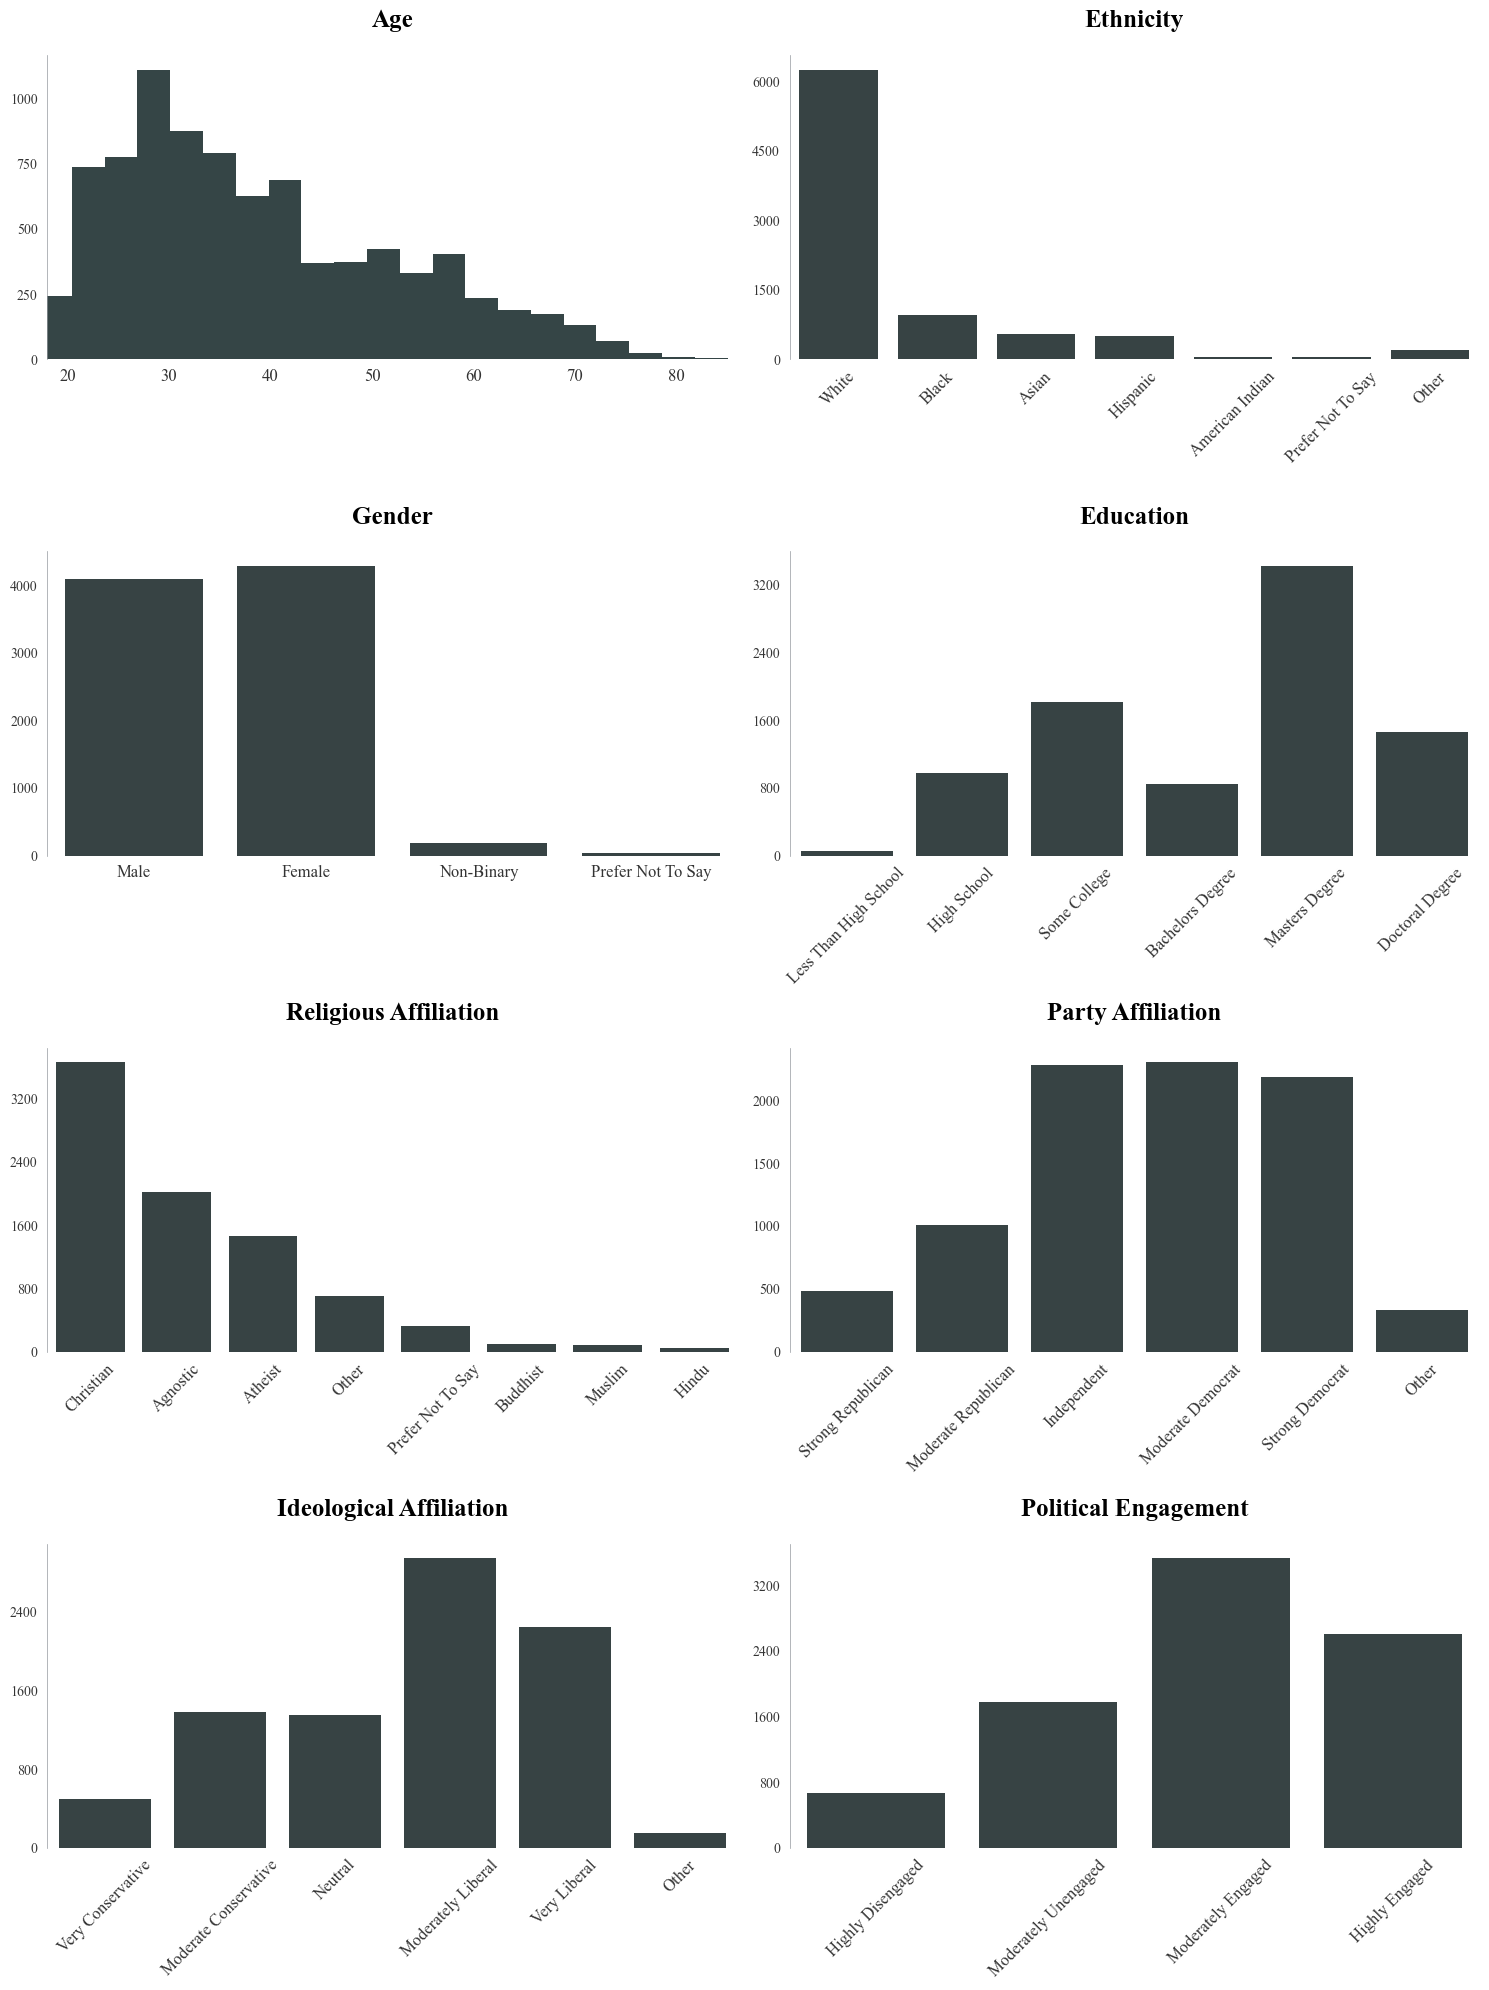

In [20]:
# Create a figure with 4 rows and 2 columns of subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# List of columns to plot
columns_to_plot = ['age', 'ethnicity', 'gender', 'education', 'religious_affiliation', 
                   'party_affiliation', 'ideological_affiliation', 'political_engagement']

# Define orders for each column
orders = {
    'ethnicity': ['white', 'black', 'asian', 'hispanic', 'american_indian', 'prefer_not_to_say', 'other'],
    'gender': ['male', 'female', 'non-binary', 'prefer_not_to_say'],
    'education': ['less_than_high_school', 'high_school', 'some_college', 'bachelors_degree', 'masters_degree', 'doctoral_degree'],
    'religious_affiliation': ['christian', 'agnostic', 'atheist', 'other', 'prefer_not_to_say', 'buddhist', 'muslim', 'hindu'],
    'party_affiliation': ['strong_republican', 'moderate_republican', 'independent', 'moderate_democrat', 'strong_democrat', 'other'],
    'ideological_affiliation': ['very_republican', 'moderate_republican', 'neutral', 'moderately_liberal', 'very_liberal', 'other'],
    'political_engagement': ['highly_disengaged', 'moderately_unengaged', 'moderately_engaged', 'highly_engaged']
}

# Iterate over each subplot and the corresponding column to plot
for ax, column in zip(axs.flatten(), columns_to_plot):
    # Use different plotting logic for categorical and numeric columns
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(df[column], kde=False, bins=30, ax=ax, color='#354546', edgecolor='none', alpha=1.0)
        if column == 'age':
            ax.set_xlim([18, 86])
    else:
        order = orders.get(column, None)
        sns.countplot(data=df, x=column, ax=ax, color='#354546', edgecolor='none', dodge=True, order=order)

    # Clean up the labels, making them horizontal and bold
    labels = [label.get_text().replace('_', ' ').title() for label in ax.get_xticklabels()]
    if column == 'ideological_affiliation':
        labels = [label.replace('Republican', 'Conservative') for label in labels]
    
    # Set rotation=0 for 'age' and 'gender' plots, otherwise set to 45
    rotation_angle = 0 if column in ['age', 'gender'] else 45
    ax.set_xticklabels(labels, rotation=rotation_angle, fontsize=12)

    # Set the new x-axis label with labelpad to adjust vertical position
    ax.set_title(column.replace("_", " ").title(), fontsize=18, weight='bold', pad=20)

    # Remove y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Adjust spines color and linewidth
    ax.spines['left'].set_color('#94999E')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Adjust tick parameters
    ax.tick_params(colors='#333333')
    ax.tick_params(left=False)
    ax.tick_params(bottom=False)
    
    # Set the maximum number of y-axis ticks to 5
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

# Save the figure as a PDF
fig.savefig('figureS1.pdf', format='pdf', bbox_inches='tight')

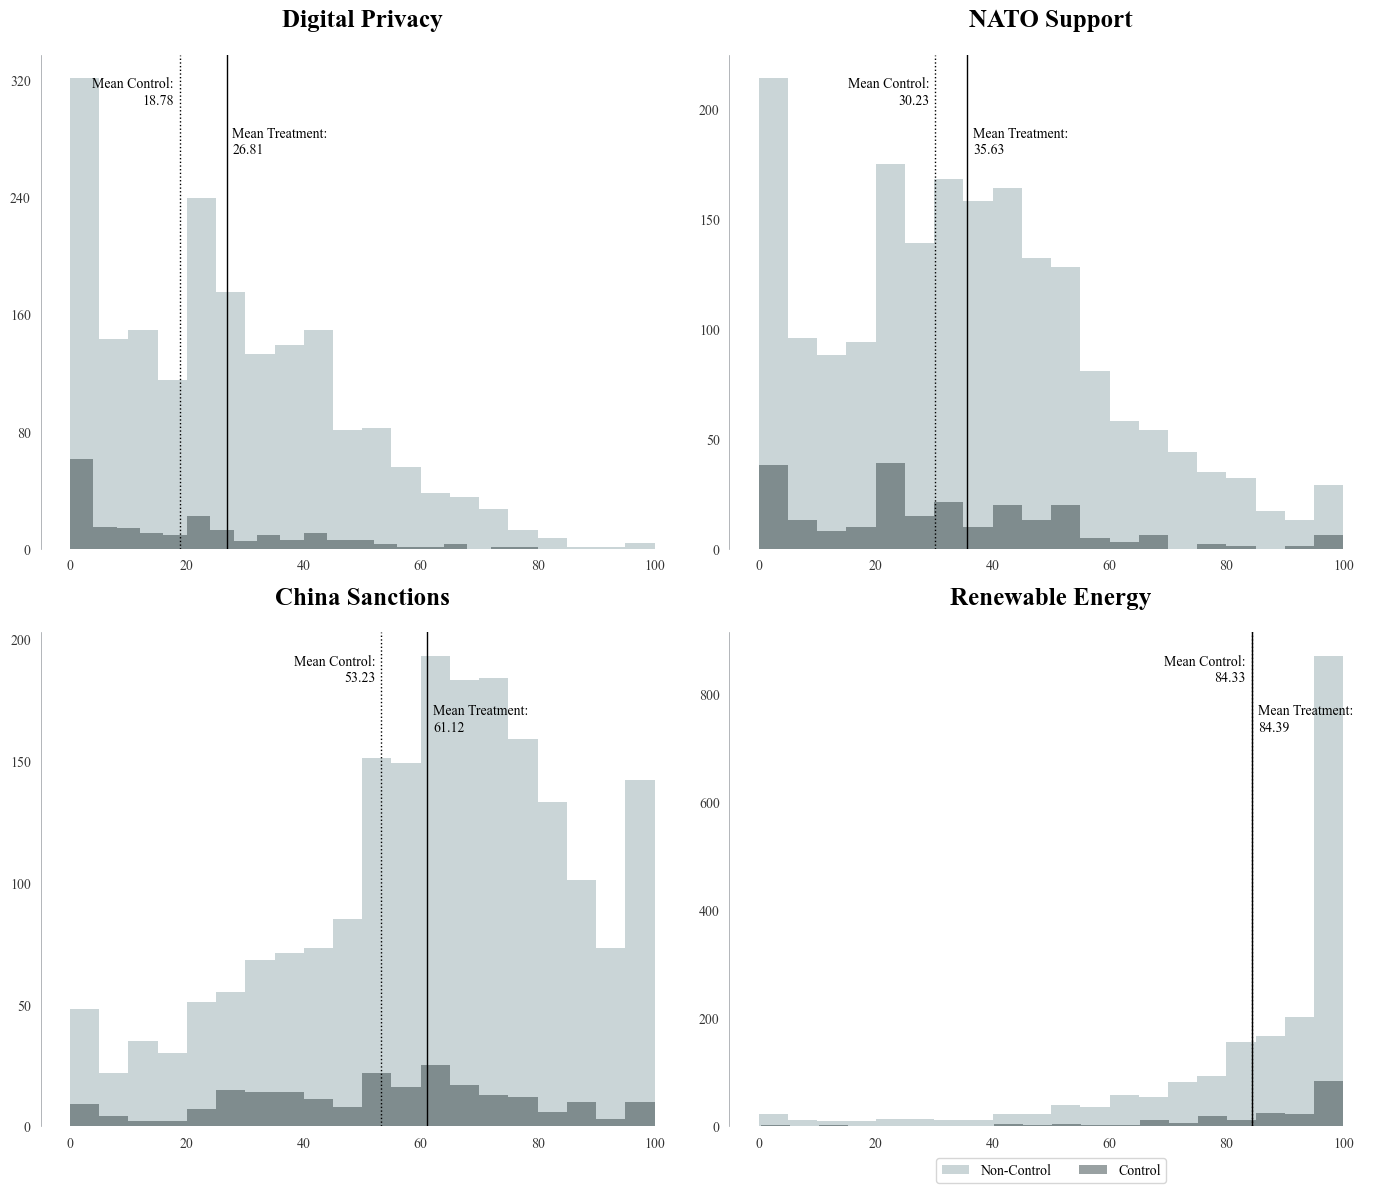

In [26]:
unique_stances = df['issue_stance'].unique()

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

titles = ["Digital Privacy", "NATO Support", "China Sanctions", "Renewable Energy"]

for i, stance in enumerate(unique_stances):
    ax = axs.flatten()[i]
    
    data_control = df[(df['issue_stance'] == stance) & (df['treatment_condition'] == "control")]['dv_response_mean']
    data_other = df[(df['issue_stance'] == stance) & (df['treatment_condition'] != "control")]['dv_response_mean']

    sns.histplot(data_other, bins=20, kde=False, ax=ax, color='#96ACB0', edgecolor='none', alpha=0.5, label='Non-Control')
    sns.histplot(data_control, bins=20, kde=False, ax=ax, color='#354546', edgecolor='none', alpha=0.5, label='Control')

    # Calculate the mean of the control and non-control conditions
    mean_control = np.mean(data_control)
    mean_other = np.mean(data_other)

    # Add vertical dotted lines with labels for the means
    ax.axvline(mean_control, color='k', linestyle='dotted', linewidth=1)
    ax.text(mean_control - 1, ax.get_ylim()[1]*0.9, f'Mean Control:\n{mean_control:.2f}', horizontalalignment='right')
    ax.axvline(mean_other, color='k', linestyle='solid', linewidth=1)
    ax.text(mean_other + 1, ax.get_ylim()[1]*0.8, f'Mean Treatment:\n{mean_other:.2f}', horizontalalignment='left')

    ax.set_title(titles[i], fontsize=18, weight='bold', pad=20)

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color('#94999E')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(colors='#333333')
    ax.tick_params(left=False)
    ax.tick_params(bottom=False)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()

fig.savefig('figureStances.pdf', format='pdf', bbox_inches='tight')
